In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import random
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

# 定义常量
NUM_CLASSES = 10
BATCH_SIZE = 256

# 图片文件夹路径
data_dir = 'raw-img'

# 使用GPU加速
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据预处理和增强
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet的输入尺寸为224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# 加载数据集
image_dataset = ImageFolder(root=data_dir, transform=data_transforms)

# 划分训练集和测试集
train_size = int(0.7 * len(image_dataset))
test_size = len(image_dataset) - train_size
train_dataset, test_dataset = random_split(image_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

# 加载预训练的ResNet-18模型
model = resnet18(pretrained=True)
# 修改分类器的输出层以适应自定义的类别数
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 20
train_corrects_history = []
test_corrects_history = []

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    train_corrects = 0
    train_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_samples += len(labels)

    train_accuracy = train_corrects.double() / train_samples
    train_corrects_history.append(train_accuracy)

    # 测试阶段
    model.eval()
    test_corrects = 0
    test_samples = 0

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)
        test_samples += len(labels)

    test_accuracy = test_corrects.double() / test_samples
    test_corrects_history.append(test_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')


/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Train Accuracy: 0.8823, Test Accuracy: 0.8034
Epoch [2/20], Train Accuracy: 0.9485, Test Accuracy: 0.8647
Epoch [3/20], Train Accuracy: 0.9569, Test Accuracy: 0.8853
Epoch [4/20], Train Accuracy: 0.9665, Test Accuracy: 0.8738
Epoch [5/20], Train Accuracy: 0.9728, Test Accuracy: 0.8888
Epoch [6/20], Train Accuracy: 0.9782, Test Accuracy: 0.8919
Epoch [7/20], Train Accuracy: 0.9822, Test Accuracy: 0.8939
Epoch [8/20], Train Accuracy: 0.9815, Test Accuracy: 0.8910
Epoch [9/20], Train Accuracy: 0.9843, Test Accuracy: 0.9175
Epoch [10/20], Train Accuracy: 0.9863, Test Accuracy: 0.8680
Epoch [11/20], Train Accuracy: 0.9905, Test Accuracy: 0.9195
Epoch [12/20], Train Accuracy: 0.9879, Test Accuracy: 0.9079
Epoch [13/20], Train Accuracy: 0.9908, Test Accuracy: 0.8969
Epoch [14/20], Train Accuracy: 0.9885, Test Accuracy: 0.9142
Epoch [15/20], Train Accuracy: 0.9895, Test Accuracy: 0.9037
Epoch [16/20], Train Accuracy: 0.9859, Test Accuracy: 0.8680
Epoch [17/20], Train Accuracy: 0.

In [2]:
# 保存模型参数
torch.save(model.state_dict(), 'pretrained_resnet_animal_classifier.pth')
print('Model parameters saved successfully.')

Model parameters saved successfully.


In [4]:
# ...

# 随机选择十张测试集图片进行预测和展示
model.eval()
selected_images = []
selected_labels = []
predicted_labels = []

for _ in range(10):
    random_idx = random.randint(0, len(test_dataset) - 1)
    random_data = test_dataset[random_idx]
    random_image, random_label = random_data[0], random_data[1]
    selected_images.append(random_image)
    selected_labels.append(image_dataset.classes[random_label])

    # 转换为PIL Image，然后进行预处理
    input_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    
    # 预测
    with torch.no_grad():
        input_tensor = input_transform(random_image).unsqueeze(0).to(device)
        output = model(input_tensor)
    
    _, predicted_idx = torch.max(output, 1)
    predicted_labels.append(image_dataset.classes[predicted_idx.item()])

# ...


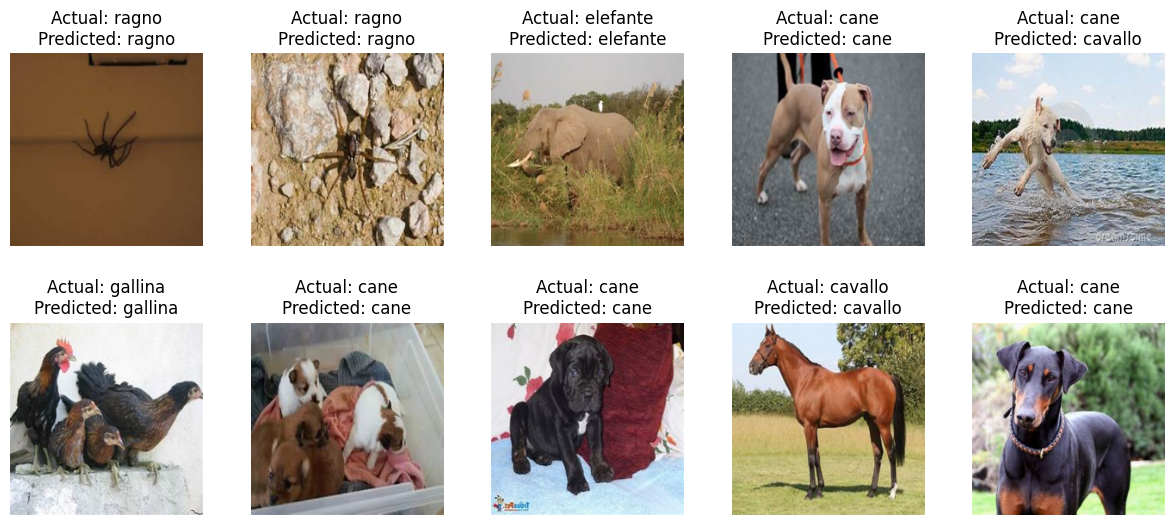

Final Train Accuracy: 0.9924
Final Test Accuracy: 0.9253


In [5]:
# 绘制预测结果
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace=0.4)
axs = axs.flatten()

for i in range(10):
    axs[i].imshow(np.array(selected_images[i]).transpose(1, 2, 0))
    axs[i].set_title(f'Actual: {selected_labels[i]}\nPredicted: {predicted_labels[i]}')
    axs[i].axis('off')

plt.show()

# 输出最终正确率
final_train_accuracy = train_corrects_history[-1].item()
final_test_accuracy = test_corrects_history[-1].item()
print(f'Final Train Accuracy: {final_train_accuracy:.4f}')
print(f'Final Test Accuracy: {final_test_accuracy:.4f}')